In [6]:
import torch
import torchvision
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from albumentations import Compose, HorizontalFlip, Rotate, Resize
from albumentations.pytorch import ToTensorV2

In [15]:
from albumentations.pytorch import ToTensorV2

class LungDataset(Dataset):
    def __init__(self, data_paths):
        self.data_paths = data_paths
        self.label2id = {label: id for id, label in enumerate([
            "Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"
        ])}

    def __getitem__(self, index):
        image_path = self.data_paths[index]
        label = Path(image_path).parent.name  # Assuming label is directory name
        transform = Compose([
            HorizontalFlip(p=0.5),
            Rotate(limit=10, p=0.25),
            Resize(256, 256),
            ToTensorV2()
        ])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transform(image=image)["image"]
        label_id = self.label2id[label]  # Make sure label is converted to ID correctly
        return image.float(), torch.tensor(label_id, dtype=torch.long)  # Ensure label is a long tensor



    def __len__(self):
        return len(self.data_paths)

In [16]:
# Define the model
class LungClassificationModel(torch.nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = torchvision.models.resnet50(pretrained=True)
        self.fc = torch.nn.Linear(self.backbone.fc.out_features, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

In [17]:
# Load data
data_path = '/content/drive/MyDrive/projectCV/data/lung_disease_dataset'
train_data_path = glob(f"{data_path}/**/train/**/*.jpeg", recursive=True)
test_data_path = glob(f"{data_path}/**/test/**/*.jpeg", recursive=True)
val_data_path = glob(f"{data_path}/**/val/**/*.jpeg", recursive=True)

train_ds = LungDataset(train_data_path)
test_ds = LungDataset(test_data_path)
val_ds = LungDataset(val_data_path)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)
test_dl = DataLoader(test_ds, batch_size=4)

# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LungClassificationModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)
criterion = torch.nn.CrossEntropyLoss()

# Metrics storage for plotting
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training and validation loop

Epoch 1 Validation: 100%|██████████| 397/397 [00:47<00:00,  8.39it/s]


Epoch 1/10
Training Loss: 0.5264, Training Accuracy: 0.7876
Validation Loss: 0.5110, Validation Accuracy: 0.7940


Epoch 2 Validation: 100%|██████████| 397/397 [00:47<00:00,  8.37it/s]


Epoch 2/10
Training Loss: 0.5000, Training Accuracy: 0.7939
Validation Loss: 1.1660, Validation Accuracy: 0.6307


Epoch 3 Validation: 100%|██████████| 397/397 [00:49<00:00,  8.08it/s]


Epoch 3/10
Training Loss: 0.4566, Training Accuracy: 0.8150
Validation Loss: 1.0386, Validation Accuracy: 0.7083


Epoch 4 Validation: 100%|██████████| 397/397 [00:47<00:00,  8.33it/s]


Epoch 4/10
Training Loss: 0.4537, Training Accuracy: 0.8127
Validation Loss: 0.4158, Validation Accuracy: 0.8393


Epoch 5 Validation: 100%|██████████| 397/397 [00:48<00:00,  8.17it/s]


Epoch 5/10
Training Loss: 0.4217, Training Accuracy: 0.8264
Validation Loss: 0.8523, Validation Accuracy: 0.6887


Epoch 6 Validation: 100%|██████████| 397/397 [00:47<00:00,  8.38it/s]


Epoch 6/10
Training Loss: 0.4102, Training Accuracy: 0.8289
Validation Loss: 0.4098, Validation Accuracy: 0.8368


Epoch 7 Validation: 100%|██████████| 397/397 [00:46<00:00,  8.46it/s]


Epoch 7/10
Training Loss: 0.3818, Training Accuracy: 0.8449
Validation Loss: 0.4529, Validation Accuracy: 0.8097


Epoch 8 Validation: 100%|██████████| 397/397 [00:46<00:00,  8.48it/s]


Epoch 8/10
Training Loss: 0.3718, Training Accuracy: 0.8505
Validation Loss: 0.3760, Validation Accuracy: 0.8399


Epoch 9 Validation: 100%|██████████| 397/397 [00:48<00:00,  8.13it/s]


Epoch 9/10
Training Loss: 0.3638, Training Accuracy: 0.8590
Validation Loss: 0.4011, Validation Accuracy: 0.8374


Epoch 10 Validation: 100%|██████████| 397/397 [00:49<00:00,  8.08it/s]


Epoch 10/10
Training Loss: 0.3393, Training Accuracy: 0.8578
Validation Loss: 0.3672, Validation Accuracy: 0.8526


Testing: 100%|██████████| 398/398 [11:03<00:00,  1.67s/it]


Test Loss: 0.3739, Test Accuracy: 0.8434, Test F1 Score: 0.8383


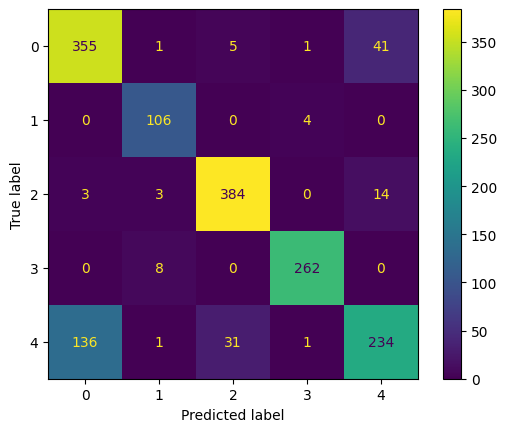

In [20]:
from tqdm import tqdm  # Make sure tqdm is imported

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    # Wrap train_dl with tqdm for a progress bar
    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1} Training"):
        images, labels = images.to(device).float(), labels.to(device)  # Convert images to float here
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    # Calculate training loss and accuracy
    epoch_train_loss = train_loss / len(train_dl)
    epoch_train_accuracy = train_correct / len(train_dl.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    val_loss, val_correct = 0, 0
    # Wrap val_dl with tqdm for a progress bar
    with torch.no_grad():
        for images, labels in tqdm(val_dl, desc=f"Epoch {epoch+1} Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    # Calculate validation loss and accuracy
    epoch_val_loss = val_loss / len(val_dl)
    epoch_val_accuracy = val_correct / len(val_dl.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Print the epoch's results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

# Optionally, you can also add tqdm for the testing phase
test_loss, test_correct = 0, 0
test_labels, test_preds = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dl, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = outputs.argmax(1)
        test_correct += (preds == labels).type(torch.float).sum().item()
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = test_correct / len(test_dl.dataset)
test_f1_score = f1_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Print final test results
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")


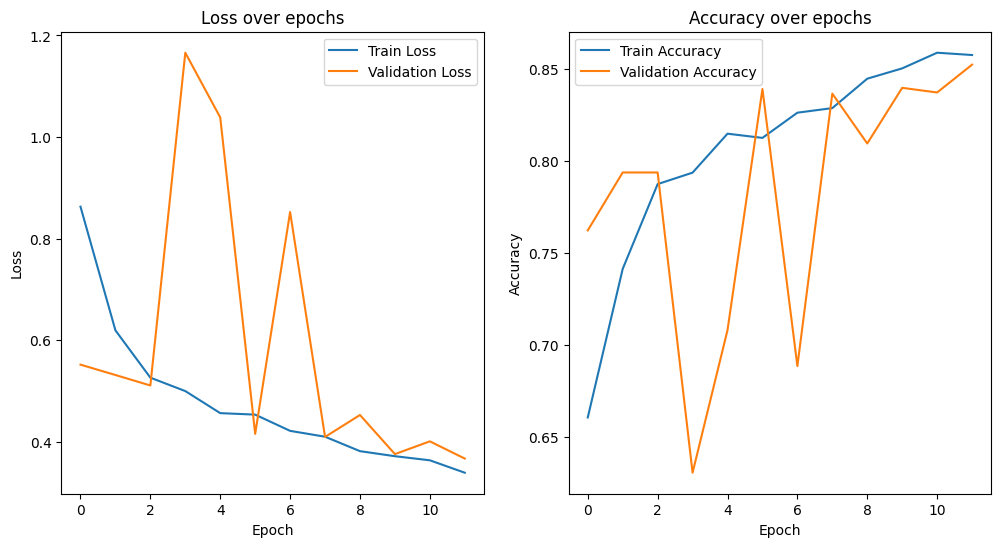

Test Loss: 0.3739, Test Accuracy: 0.8434, Test F1 Score: 0.8383


In [21]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")